In [1]:
import numpy as np
import pandas as pd
import os 
import time
import deepdish.io as dd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler

from utils.inference import SVI
import utils.models as m
import utils.datasets as d

# Load and Prepare Data

In [2]:
X = np.vstack((np.load("data/sequenced_data_for_VAE_length-160_stride-10_pt1.npy"),
               np.load("data/sequenced_data_for_VAE_length-160_stride-10_pt2.npy")))
y = np.load("data/sequenced_data_for_VAE_length-160_stride-10_targets.npy")

In [3]:
X.shape

(83680, 160)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.2, random_state=666)

In [5]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
train = d.H_alphaSequences(X_train, y_train)
test = d.H_alphaSequences(X_test, y_test)

In [7]:
train_loader = torch.utils.data.DataLoader(dataset = train, batch_size=512, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test, batch_size=512, shuffle=True)

# Model setup

In [12]:
vae = m.CBN_VAE(original_dim=160, latent_dim=30)

In [13]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

In [14]:
svi = SVI(
        vae_model=vae,
        optimizer=optimizer,
        loss_function="GaussianNLL",
        scheduler=torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[70], gamma=0.1),
        tensorboard=True,
        model_name = "CNN-VAE_ReLU_NLL_lr-{1e-3, 1e-4}_bs-512_ls-30",
        verbose=True
        )

cuda:0


In [15]:
lh = svi(epochs=200, train_loader=train_loader, validation_loader=test_loader, flatten=False)

Epoch [1/200], average_loss:40.6495, validation_loss:-46.5079
Epoch [2/200], average_loss:-53.8468, validation_loss:-87.9365
Epoch [3/200], average_loss:-73.1425, validation_loss:-96.6387
Epoch [4/200], average_loss:-87.2868, validation_loss:-101.7922
Epoch [5/200], average_loss:-96.0424, validation_loss:-112.3731
Epoch [6/200], average_loss:-94.3790, validation_loss:-114.7294
Epoch [7/200], average_loss:-99.8181, validation_loss:-99.4550
Epoch [8/200], average_loss:-102.5147, validation_loss:-119.1119
Epoch [9/200], average_loss:-107.1853, validation_loss:-126.2534
Epoch [10/200], average_loss:-107.9092, validation_loss:-113.0092
Epoch [11/200], average_loss:-117.3127, validation_loss:-144.6634
Epoch [12/200], average_loss:-113.2916, validation_loss:-148.4787
Epoch [13/200], average_loss:-120.1991, validation_loss:-122.0866
Epoch [14/200], average_loss:-110.7228, validation_loss:-148.0522
Epoch [15/200], average_loss:-118.7932, validation_loss:-106.7886
Epoch [16/200], average_loss:-1

Epoch [126/200], average_loss:-224.1693, validation_loss:-229.6648
Epoch [127/200], average_loss:-224.0396, validation_loss:-234.4465
Epoch [128/200], average_loss:-224.2731, validation_loss:-234.2653
Epoch [129/200], average_loss:-219.7315, validation_loss:-228.6627
Epoch [130/200], average_loss:-225.3093, validation_loss:-230.6865
Epoch [131/200], average_loss:-225.0373, validation_loss:-233.8514
Epoch [132/200], average_loss:-225.4172, validation_loss:-233.2617
Epoch [133/200], average_loss:-224.9930, validation_loss:-225.5435
Epoch [134/200], average_loss:-221.6336, validation_loss:-223.1472
Epoch [135/200], average_loss:-225.6197, validation_loss:-234.5432
Epoch [136/200], average_loss:-225.7789, validation_loss:-233.8924
Epoch [137/200], average_loss:-224.8187, validation_loss:-234.7101
Epoch [138/200], average_loss:-224.8752, validation_loss:-235.2606
Epoch [139/200], average_loss:-226.9973, validation_loss:-234.8756
Epoch [140/200], average_loss:-224.6316, validation_loss:-234.

# Evaluation

In [ ]:
#torch.save(svi.model, "models_and_losses/CNN-VAE_ReLU_NLL_lr-{1e-3,1e-4}_bs-512_epoch-200.pt")
#torch.save(svi.optimizer, "models_and_losses/CNN-VAE_ReLU_NLL_lr-{1e-3,1e-4}_bs-512_epoch-200_optimizer.pt")

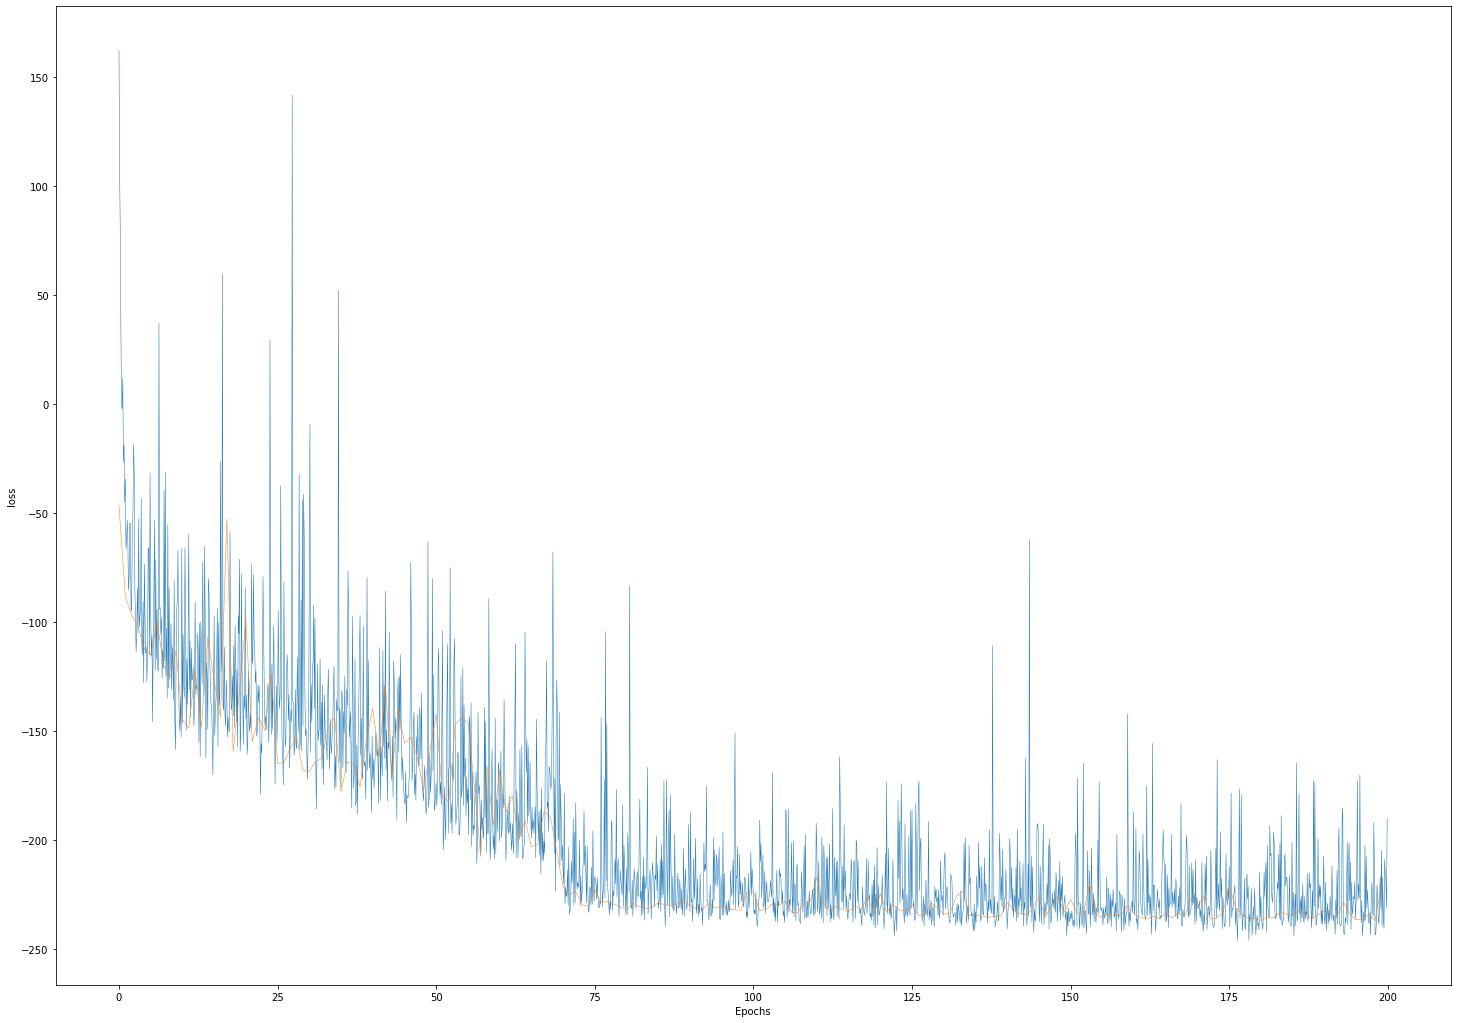

In [16]:
from utils.inference import plot_loss
plot_loss(svi)

cuda:0


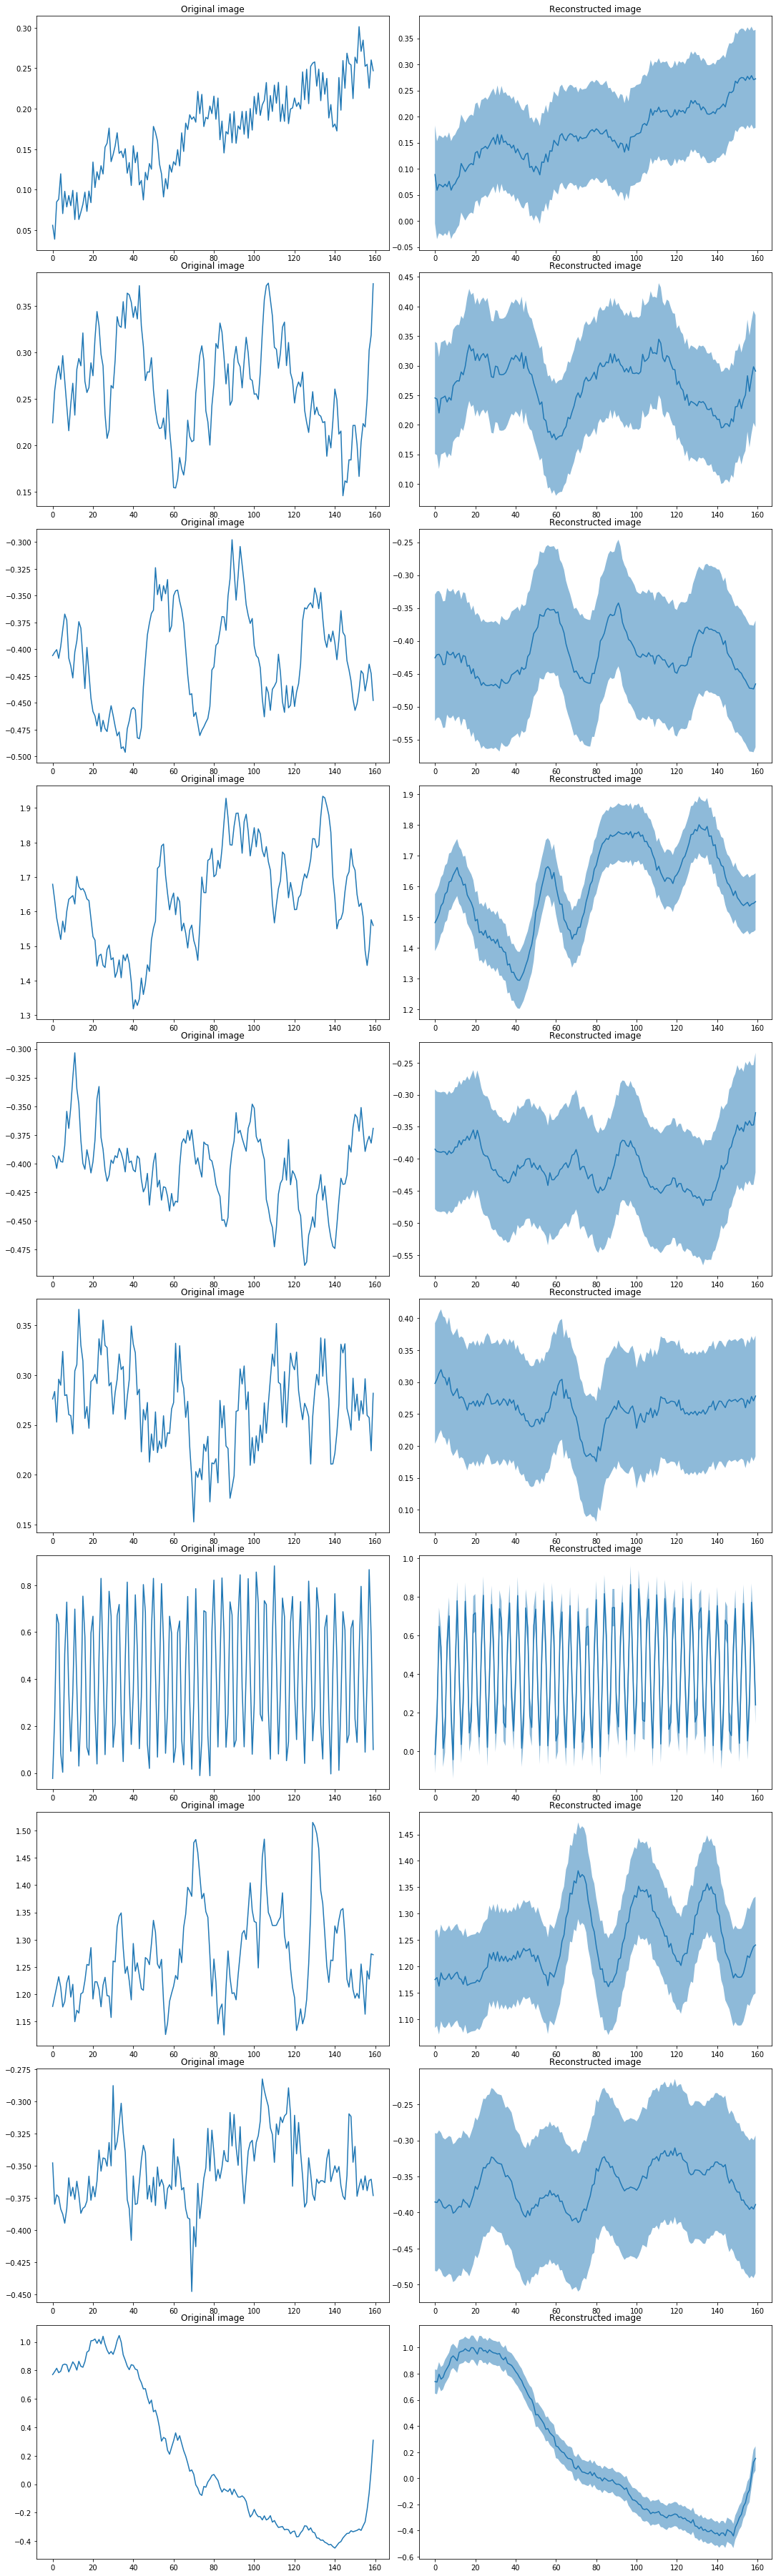

In [17]:
# epoch 100
print(svi.device)
X,_ = next(iter(test_loader))
output, mu, sigma = svi.model(X.to(svi.device))
#X_hat = output.cpu().detach().numpy()
mu_hat = output[0].cpu().detach().numpy()
sigma = output[1].cpu().detach().numpy()

fig, axes = plt.subplots(10, 2, figsize=(15,50))
fig.tight_layout()
for i in range(10):
    axes[i][0].plot(X[i])
    axes[i][0].set_title('Original image')
    #axes[i][1].plot(X_hat[i])
    axes[i][1].plot(mu_hat[i])
    axes[i][1].fill_between(np.arange(160), mu_hat[i] + 2 * sigma[i], mu_hat[i] - 2 * sigma[i], alpha = 0.5, label="Uncertainty")
    axes[i][1].set_title('Reconstructed image')

cuda:0


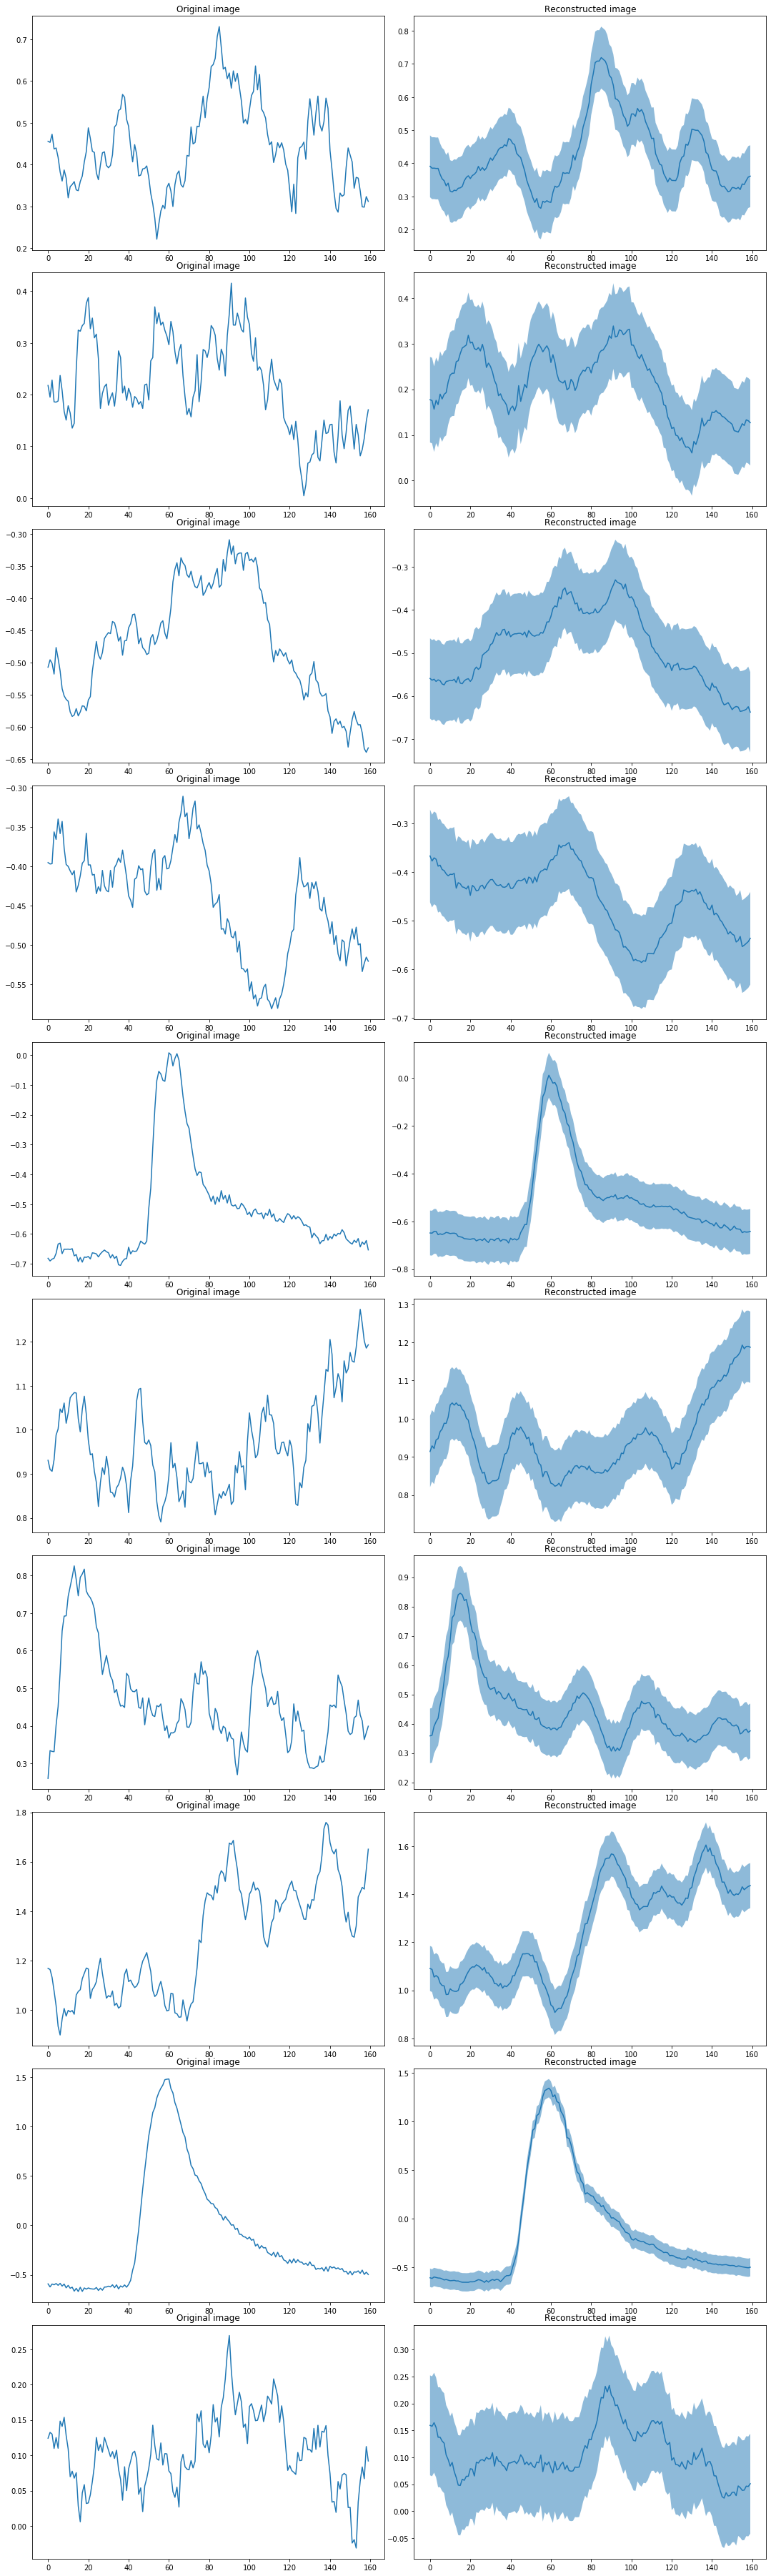

In [18]:
# epoch 100
print(svi.device)
X,_ = next(iter(test_loader))
output, mu, sigma = svi.model(X.to(svi.device))
#X_hat = output.cpu().detach().numpy()
mu_hat = output[0].cpu().detach().numpy()
sigma = output[1].cpu().detach().numpy()

fig, axes = plt.subplots(10, 2, figsize=(15,50))
fig.tight_layout()
for i in range(10):
    axes[i][0].plot(X[i])
    axes[i][0].set_title('Original image')
    #axes[i][1].plot(X_hat[i])
    axes[i][1].plot(mu_hat[i])
    axes[i][1].fill_between(np.arange(160), mu_hat[i] + 2 * sigma[i], mu_hat[i] - 2 * sigma[i], alpha = 0.5, label="Uncertainty")
    axes[i][1].set_title('Reconstructed image')

In [19]:
lh = svi(epochs=range(200,300), train_loader=train_loader, validation_loader=test_loader, flatten=False)

Epoch [201/300], average_loss:-223.8716, validation_loss:-235.3430
Epoch [202/300], average_loss:-226.8284, validation_loss:-233.5791
Epoch [203/300], average_loss:-230.2675, validation_loss:-236.4331
Epoch [204/300], average_loss:-227.8359, validation_loss:-229.6821
Epoch [205/300], average_loss:-227.6441, validation_loss:-234.2181
Epoch [206/300], average_loss:-230.2144, validation_loss:-237.1221
Epoch [207/300], average_loss:-228.7741, validation_loss:-231.5967
Epoch [208/300], average_loss:-230.0217, validation_loss:-233.8243
Epoch [209/300], average_loss:-229.3472, validation_loss:-236.5328
Epoch [210/300], average_loss:-228.3163, validation_loss:-233.8579
Epoch [211/300], average_loss:-227.9924, validation_loss:-236.3015
Epoch [212/300], average_loss:-226.6483, validation_loss:-236.7252
Epoch [213/300], average_loss:-228.2279, validation_loss:-230.7180
Epoch [214/300], average_loss:-229.6264, validation_loss:-235.8234
Epoch [215/300], average_loss:-230.2566, validation_loss:-236.

cuda:0


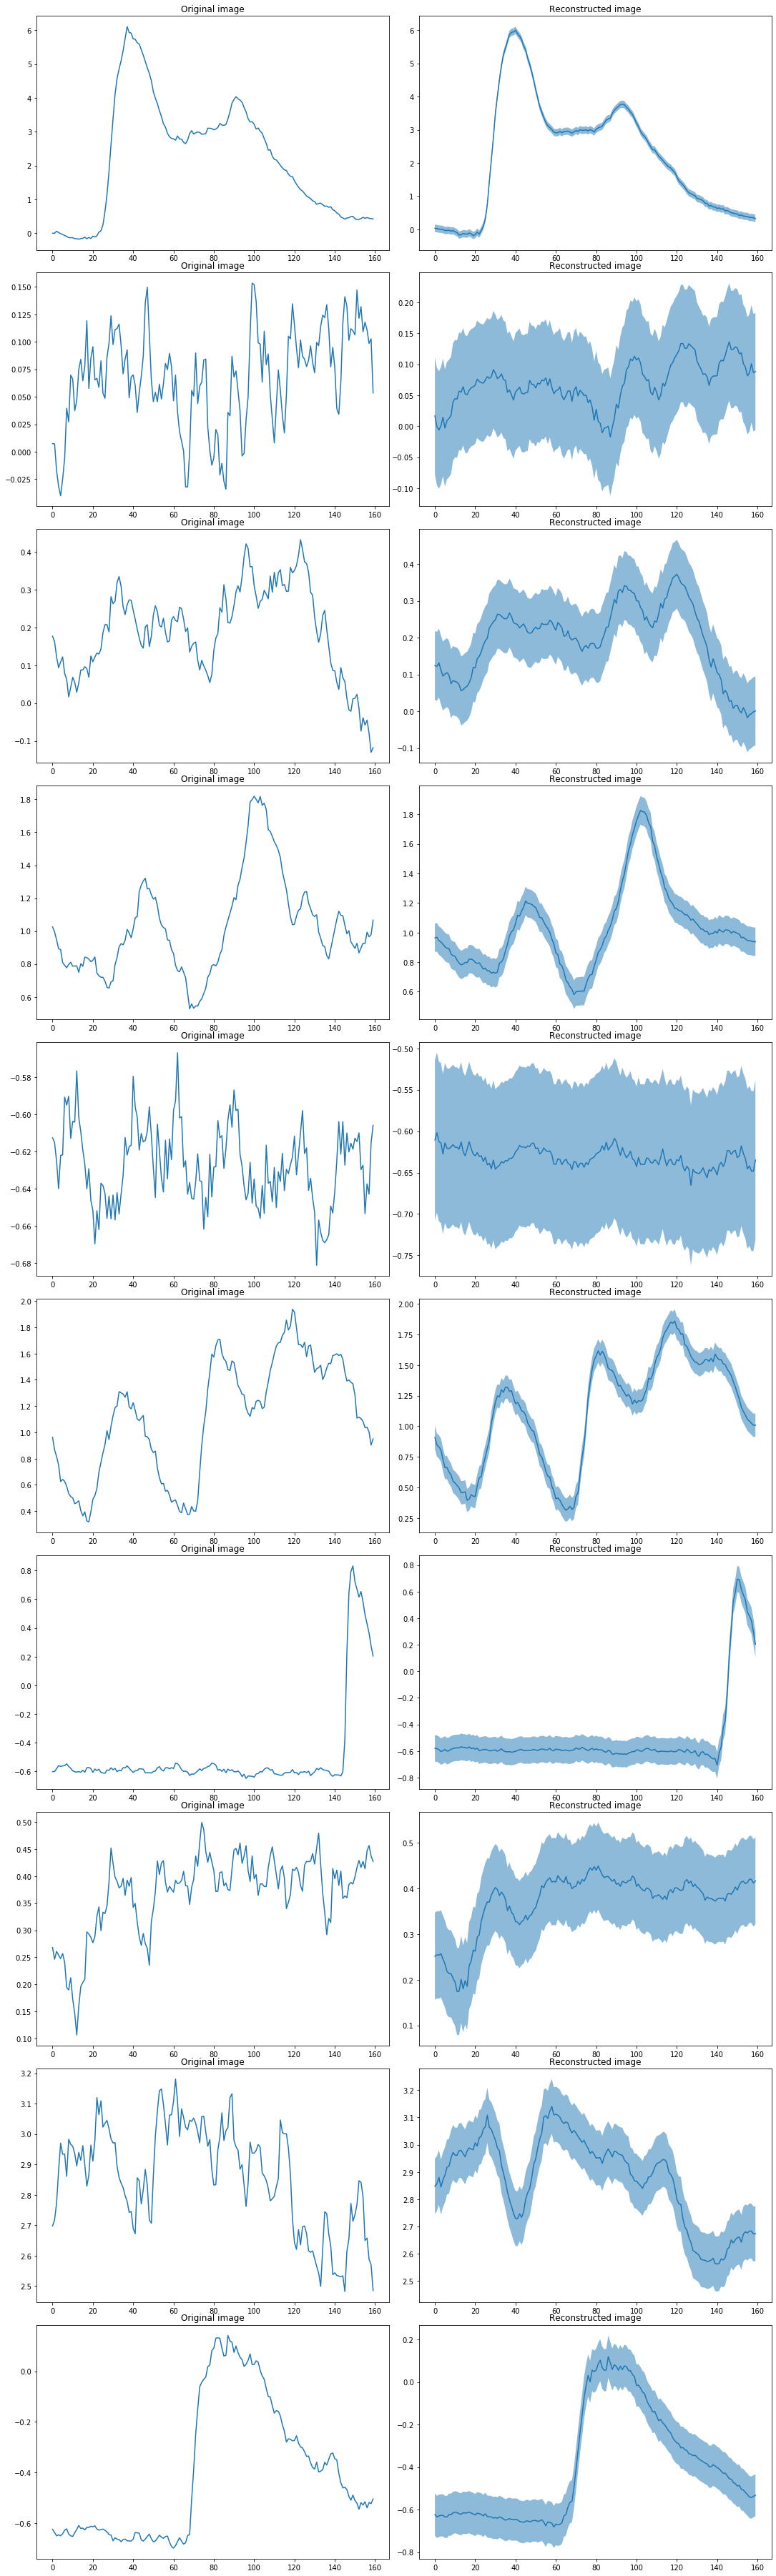

In [20]:
# epoch 100
print(svi.device)
X,_ = next(iter(test_loader))
output, mu, sigma = svi.model(X.to(svi.device))
#X_hat = output.cpu().detach().numpy()
mu_hat = output[0].cpu().detach().numpy()
sigma = output[1].cpu().detach().numpy()

fig, axes = plt.subplots(10, 2, figsize=(15,50))
fig.tight_layout()
for i in range(10):
    axes[i][0].plot(X[i])
    axes[i][0].set_title('Original image')
    #axes[i][1].plot(X_hat[i])
    axes[i][1].plot(mu_hat[i])
    axes[i][1].fill_between(np.arange(160), mu_hat[i] + 2 * sigma[i], mu_hat[i] - 2 * sigma[i], alpha = 0.5, label="Uncertainty")
    axes[i][1].set_title('Reconstructed image')

In [21]:
#torch.save(svi.model, "models_and_losses/CNN-VAE_ReLU_NLL_lr-{1e-3,1e-4}_bs-512_ls-30_epoch-300.pt")
&torch.save(svi.optimizer, "models_and_losses/CNN-VAE_ReLU_NLL_lr-{1e-3,1e-4}_bs-512_ls-30_epoch-300_optimizer.pt")

C:\Users\ghost_000\Miniconda3\envs\Pytorch\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type CBN_VAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\ghost_000\Miniconda3\envs\Pytorch\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\ghost_000\Miniconda3\envs\Pytorch\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Reshape. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\ghost_000\Miniconda3\envs\Pytorch\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv1d. It won't be checked for correctness upon

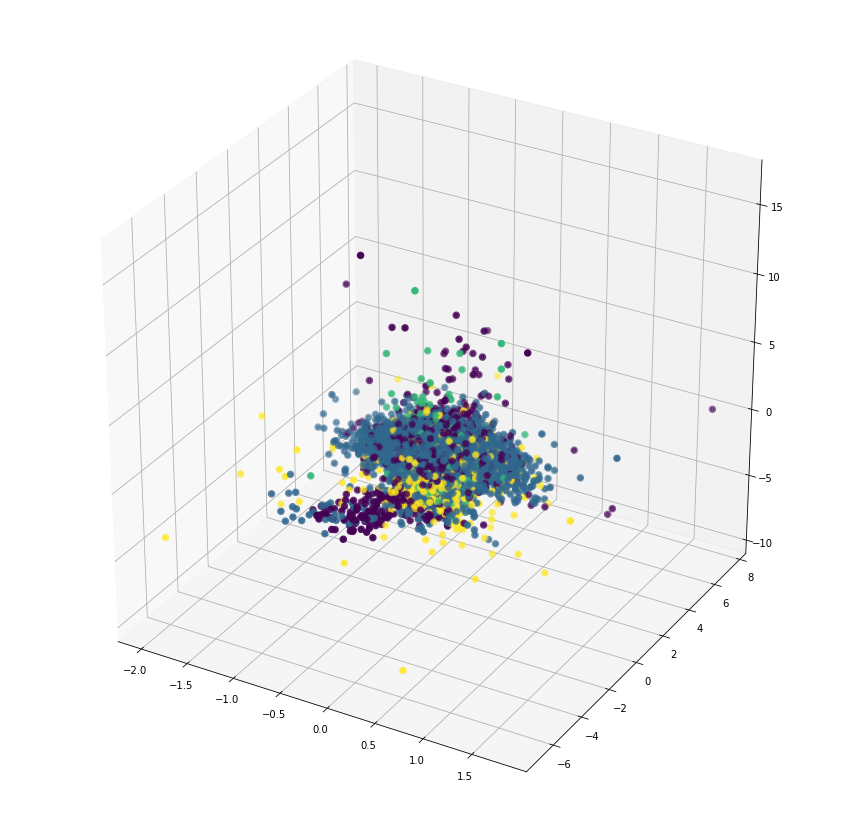

In [22]:
# epoch 200
X_1, cl = test.X, test.y
Z_hat, mu, sigma = svi.model.encoder(X_1.to(svi.device)) #.view(-1,28*28)
Z_hat = Z_hat.cpu().detach().numpy()
mu = mu.cpu().detach().numpy()

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(Z_hat[:,0], Z_hat[:,1], Z_hat[:,2], c=cl, lw=3)
sc = ax.scatter(mu[:,0], mu[:,1], mu[:,2], c=cl, lw=3)

In [ ]:
X.shape

In [ ]:
mod = torch.load("models_and_losses/CNN-VAE_ReLU_NLL_lr-{1e-3,1e-4}_bs-512_epoch-300.pt")

In [ ]:
mod.eval()
Z_hat1, mu1, sigma1 = mod.encoder(torch.tensor(X_train[:42340,:]).float().cuda()) #.view(-1,28*28)
mu1 = mu1.cpu().detach().numpy()

In [ ]:
mod.eval()
_, mu2, _ = mod.encoder(torch.tensor(X_train[42340:,:]).float().cuda()) #.view(-1,28*28)
mu2 = mu2.cpu().detach().numpy()

In [ ]:
mod.eval()
_, mu_t, _ = mod.encoder(torch.tensor(X_test).float().cuda()) #.view(-1,28*28)
mu_t = mu_t.cpu().detach().numpy()

In [ ]:
mu1.shape

In [ ]:
mu2.shape

In [ ]:
mu = np.vstack((mu1,mu2))
mu.shape

In [ ]:
#np.save("data/enocoded_data_train_CNN-VAE_ReLU_NLL_lr-{1e-3,1e-4}_bs-512_epoch-300.npy", mu)

In [ ]:
#np.save("data/enocoded_data_test_CNN-VAE_ReLU_NLL_lr-{1e-3,1e-4}_bs-512_epoch-300.npy", mu_t)